Тестовая Задача

Условие задачи: создать модель, которая должна определять цвет автомобиля по его фотографии

Ссылки: В качестве датасета для обучения я использовал вариацию stanford car dataset в которой автомобили разделены на 196 групп(https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder)

Архитектуру нейронной сети и некоторые идеи взял отсюда - https://github.com/beerboaa/Color-Classification-CNN

Словарь с названиями цветов - https://github.com/codebrainz/color-names/blob/master/output/colors.csv

In [1]:
pip install ColorThief

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Загрузка необходимых компонентов
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from colorthief import ColorThief
from PIL import Image
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization, Lambda, AveragePooling2D, ZeroPadding2D, Reshape, Activation, Concatenate
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

### Подготовка данных

In [4]:
# Загрузка обучающей выборки
car_train = "C:/Datasets/Test_task_cv/train/"
print('Всего', len(os.listdir(car_train)),'классов в тестовой выборке')

Всего 196 классов в тестовой выборке


In [5]:
mylist = []
for labels in os.listdir(car_train):
    for label in os.listdir(car_train+labels): 
        car_add = car_train + labels + '/' + label
        car_value = (labels, car_add)                
        if car_value not in mylist:
            mylist.append(car_value)
            
train_df = pd.DataFrame(np.array(mylist), columns= ["car", "image path"])

In [6]:
train_df.sample(10)

,car,image path
4880,Geo Metro Convertible 1993,C:/Datasets/Test_task_cv/train/Geo Metro Conve...
3545,Dodge Charger Sedan 2012,C:/Datasets/Test_task_cv/train/Dodge Charger S...
2575,Chevrolet Malibu Hybrid Sedan 2010,C:/Datasets/Test_task_cv/train/Chevrolet Malib...
2683,Chevrolet Monte Carlo Coupe 2007,C:/Datasets/Test_task_cv/train/Chevrolet Monte...
3155,Chrysler Aspen SUV 2009,C:/Datasets/Test_task_cv/train/Chrysler Aspen ...
4923,GMC Acadia SUV 2012,C:/Datasets/Test_task_cv/train/GMC Acadia SUV ...
2608,Chevrolet Malibu Sedan 2007,C:/Datasets/Test_task_cv/train/Chevrolet Malib...
7995,Volkswagen Golf Hatchback 2012,C:/Datasets/Test_task_cv/train/Volkswagen Golf...
7110,Plymouth Neon Coupe 1999,C:/Datasets/Test_task_cv/train/Plymouth Neon C...
1053,Bentley Arnage Sedan 2009,C:/Datasets/Test_task_cv/train/Bentley Arnage ...


In [7]:
#Создаю тестовую выборку
car_test= "C:/Datasets/Test_task_cv/test/"

In [8]:
mylist2 = []
for labels in os.listdir(car_test):
    for label in os.listdir(car_test+labels): 
        car_add = car_test + labels + '/' + label
        car_value = (labels, car_add)                
        if car_value not in mylist:
            mylist2.append(car_value)   

test_df = pd.DataFrame(np.array(mylist2), columns= ["car", "image path"])

In [9]:
test_df.sample(10)

,car,image path
7532,Suzuki SX4 Hatchback 2012,C:/Datasets/Test_task_cv/test/Suzuki SX4 Hatch...
3997,Eagle Talon Hatchback 1998,C:/Datasets/Test_task_cv/test/Eagle Talon Hatc...
5910,Jeep Compass SUV 2012,C:/Datasets/Test_task_cv/test/Jeep Compass SUV...
97,Acura TL Sedan 2012,C:/Datasets/Test_task_cv/test/Acura TL Sedan 2...
398,Aston Martin Virage Convertible 2012,C:/Datasets/Test_task_cv/test/Aston Martin Vir...
3656,Dodge Dakota Crew Cab 2010,C:/Datasets/Test_task_cv/test/Dodge Dakota Cre...
6149,Lamborghini Diablo Coupe 2001,C:/Datasets/Test_task_cv/test/Lamborghini Diab...
8035,Volvo XC90 SUV 2007,C:/Datasets/Test_task_cv/test/Volvo XC90 SUV 2...
1397,BMW 3 Series Wagon 2012,C:/Datasets/Test_task_cv/test/BMW 3 Series Wag...
6070,Jeep Wrangler SUV 2012,C:/Datasets/Test_task_cv/test/Jeep Wrangler SU...


### Создание возможности для цветовой классификации

In [10]:
clr_headers = ['color', 'full_name', 'hex', 'r', 'g', 'b']
colors = pd.read_csv('C:/Datasets/Test_task_cv/colors.csv', names=clr_headers, index_col = 'color')
colors['rgb'] = list(zip(colors['r'], colors['g'], colors['b'])) 
colors_df = colors.drop(columns=['full_name', 'hex', 'r', 'g', 'b']) 
colors_dict = dict(zip(colors_df.index, colors_df['rgb']))

# Данная функция должна найти доминирующий цвет и вернуть код RGB

def classify_color(filepath):
    color_thief = ColorThief(filepath)
    dominant_color = color_thief.get_color(quality=1)

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) 
    
    distances = {k: manhattan(v, dominant_color) for k, v in colors_dict.items()}
    
    color = min(distances, key=distances.get) 
    return color
# Идея функции заключается в том, чтобы найти цвет из словаря с самой короткой Манхеттенской динстацией

### Категоризация выборок

Тут я должен пояснить, что процесс категоризации достаточно затратный по ресурсам и он занял у меня всю ночь. Для того чтобы можно было использовать результаты этих вычислений не тратя кучу времени, я решил сохранить эти результаты как отдельные файлы, и использовать их в дальнейшем

In [11]:
#Тестовая выборка
train_df = pd.read_csv('C:/Datasets/Test_task_cv/train_df_color.csv')
train_df = train_df[['car', 'image path', 'color', 'car label']]

In [12]:
train_df['car_label'] = train_df.color.astype("category").cat.codes
train_df['car_label'] = train_df['car_label'].astype("str")

In [13]:
# вывожу наиболее распостранёные цвета
train_df.groupby(train_df['car_label']).count().sort_values(by='color', ascending=False).head(10)

,car,image path,color,car label
car_label,,,,
104,608,608,608,608
75,433,433,433,433
20,426,426,426,426
19,347,347,347,347
58,343,343,343,343
8,339,339,339,339
133,330,330,330,330
134,314,314,314,314
183,284,284,284,284


In [14]:
train_img_df = train_df[['image path', 'car_label']].copy()
train_img_df.sample(5)

,image path,car_label
3766,C:/Datasets/Test_task_cv/train/Dodge Durango S...,109
1142,C:/Datasets/Test_task_cv/train/Bentley Contine...,181
5739,C:/Datasets/Test_task_cv/train/Hyundai Veloste...,144
2092,C:/Datasets/Test_task_cv/train/Cadillac Escala...,19
4160,C:/Datasets/Test_task_cv/train/Ferrari Califor...,156


In [15]:
train_img_df.shape

(8144, 2)

In [16]:
# повторяю процедуры на тестовой выборке
test_df = pd.read_csv("C:/Datasets/Test_task_cv/test_df_color.csv")
test_df['car_label'] = test_df.color.astype("category").cat.codes
test_df['car_label'] = test_df['car_label'].astype("str")

In [17]:
test_df.head()

,Unnamed: 0,car,image path,color,car_label
0,0,Acura Integra Type R 2001,C:/Datasets/Test_task_cv/test/Acura Integra Ty...,grullo,106
1,1,Acura Integra Type R 2001,C:/Datasets/Test_task_cv/test/Acura Integra Ty...,jet,111
2,2,Acura Integra Type R 2001,C:/Datasets/Test_task_cv/test/Acura Integra Ty...,light_gray,121
3,3,Acura Integra Type R 2001,C:/Datasets/Test_task_cv/test/Acura Integra Ty...,lavender_gray,117
4,4,Acura Integra Type R 2001,C:/Datasets/Test_task_cv/test/Acura Integra Ty...,arsenic,6


In [18]:
test_df.groupby(test_df['car_label']).count().sort_values(by='color', ascending=False)

,Unnamed: 0,car,image path,color
car_label,,,,
111,591,591,591,591
82,465,465,465,465
21,438,438,438,438
20,376,376,376,376
66,349,349,349,349
...,...,...,...,...
153,1,1,1,1
155,1,1,1,1
29,1,1,1,1


In [19]:
test_img_df = test_df[['image path', 'car_label']].copy()
test_img_df.sample(5)

,image path,car_label
7192,C:/Datasets/Test_task_cv/test/Rolls-Royce Phan...,183
4359,C:/Datasets/Test_task_cv/test/Ford Expedition ...,66
6743,C:/Datasets/Test_task_cv/test/Mercedes-Benz Sp...,111
3342,C:/Datasets/Test_task_cv/test/Dodge Caliber Wa...,145
5333,C:/Datasets/Test_task_cv/test/Hyundai Azera Se...,67


In [20]:
test_img_df['image path'].head()

0    C:/Datasets/Test_task_cv/test/Acura Integra Ty...
1    C:/Datasets/Test_task_cv/test/Acura Integra Ty...
2    C:/Datasets/Test_task_cv/test/Acura Integra Ty...
3    C:/Datasets/Test_task_cv/test/Acura Integra Ty...
4    C:/Datasets/Test_task_cv/test/Acura Integra Ty...
Name: image path, dtype: object

In [21]:
test_img_df.shape

(8041, 2)

### Генераторы изображений

Они мне необходимы для преобразования данных в необходимый формат

In [22]:
datagen = ImageDataGenerator(rescale=1./255,       
                             shear_range=0.2,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             brightness_range=[0.5,1.5],
                             validation_split=0.25)

In [23]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train_img_df,
    directory = None,
    x_col="image path",
    y_col="car_label",
    has_ext=True,                                     
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224), 
    color_mode='rgb',
    validate_filenames=False
)

Found 6108 non-validated image filenames belonging to 200 classes.


In [24]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_img_df,
    directory = None, 
    x_col="image path",
    y_col="car_label",
    has_ext=True,
    subset="validation",
    batch_size=2,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224), 
    color_mode='rgb',
    validate_filenames=False
)

Found 2036 non-validated image filenames belonging to 200 classes.


In [25]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [26]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_img_df,

    directory = None,
    x_col="image path",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False, 
    class_mode=None, 
    target_size=(224,224),
    color_mode ='rgb'
)

Found 8041 validated image filenames.


In [27]:
step_train = train_generator.n//train_generator.batch_size
step_valid = valid_generator.n//valid_generator.batch_size
step_test = test_generator.n//test_generator.batch_size

### Создание нейронной сети

In [28]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [29]:
num_classes = 200
nb_epoch = 15

# initialise model
model = color_net(num_classes)

filepath = 'color_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit(
                    train_generator,
                    steps_per_epoch=step_train,
                    epochs=nb_epoch,
                    validation_data=valid_generator,
                    validation_steps=step_valid,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/15
190/190 [==============================] - ETA: 0s - loss: 4.1772 - accuracy: 0.0648
Epoch 1: val_accuracy improved from -inf to 0.10118, saving model to color_weights.hdf5


C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 430s 2s/step - loss: 4.1772 - accuracy: 0.0648 - val_loss: 4.1753 - val_accuracy: 0.1012
Epoch 2/15
190/190 [==============================] - ETA: 0s - loss: 3.9278 - accuracy: 0.0904
Epoch 2: val_accuracy did not improve from 0.10118
190/190 [==============================] - 353s 2s/step - loss: 3.9278 - accuracy: 0.0904 - val_loss: 3.9291 - val_accuracy: 0.0712
Epoch 3/15
190/190 [==============================] - ETA: 0s - loss: 3.7929 - accuracy: 0.0994
Epoch 3: val_accuracy did not improve from 0.10118
190/190 [==============================] - 281s 1s/step - loss: 3.7929 - accuracy: 0.0994 - val_loss: 3.8689 - val_accuracy: 0.0869
Epoch 4/15
190/190 [==============================] - ETA: 0s - loss: 3.6616 - accuracy: 0.1175
Epoch 4: val_accuracy improved from 0.10118 to 0.11100, saving model to color_weights.hdf5
190/190 [==============================] - 283s 1s/step - loss: 3.6616 - accuracy: 0.1175 - val_loss: 3.6853 - val_accuracy

### Оценка

In [30]:
model.evaluate(
    valid_generator, 
    steps=step_valid, 
    verbose=1)

1018/1018 [==============================] - 59s 58ms/step - loss: 3.2188 - accuracy: 0.1582


[3.2187631130218506, 0.158153235912323]

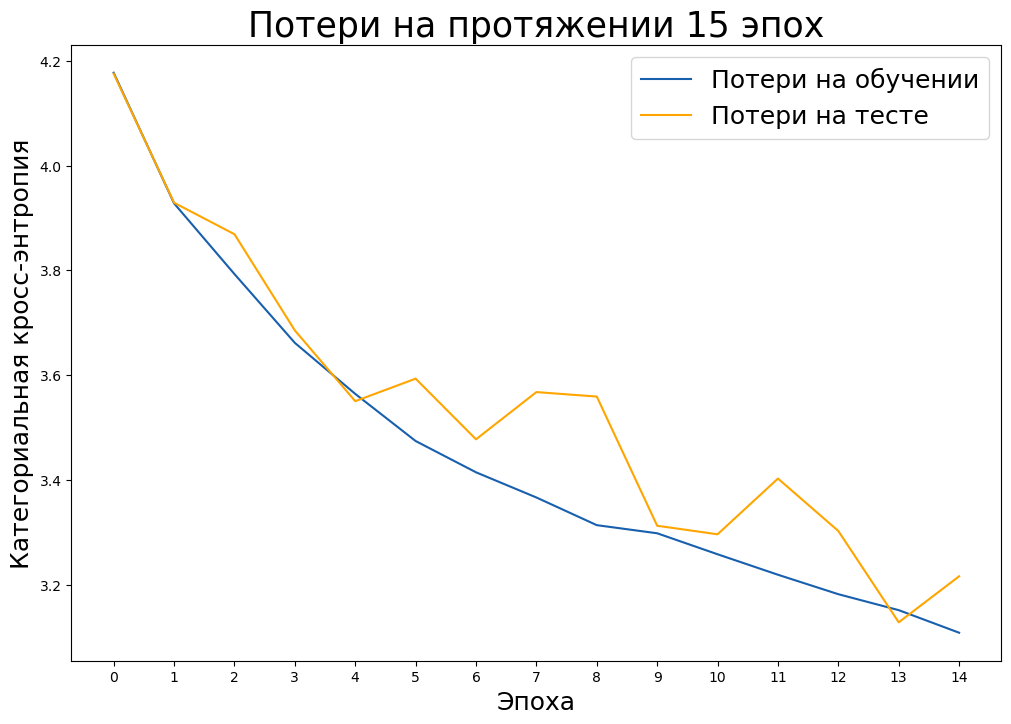

In [31]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']


plt.figure(figsize=(12, 8))

# Создаю график изменения потерь на протяжении эпох
plt.plot(train_loss, label='Потери на обучении', color='#185fad')
plt.plot(test_loss, label='Потери на тесте', color='orange')

# Set title
plt.title('Потери на протяжении 15 эпох', fontsize = 25)
plt.xlabel('Эпоха', fontsize = 18)
plt.ylabel('Категориальная кросс-энтропия', fontsize = 18)
plt.xticks(range(15))

plt.legend(fontsize = 18);

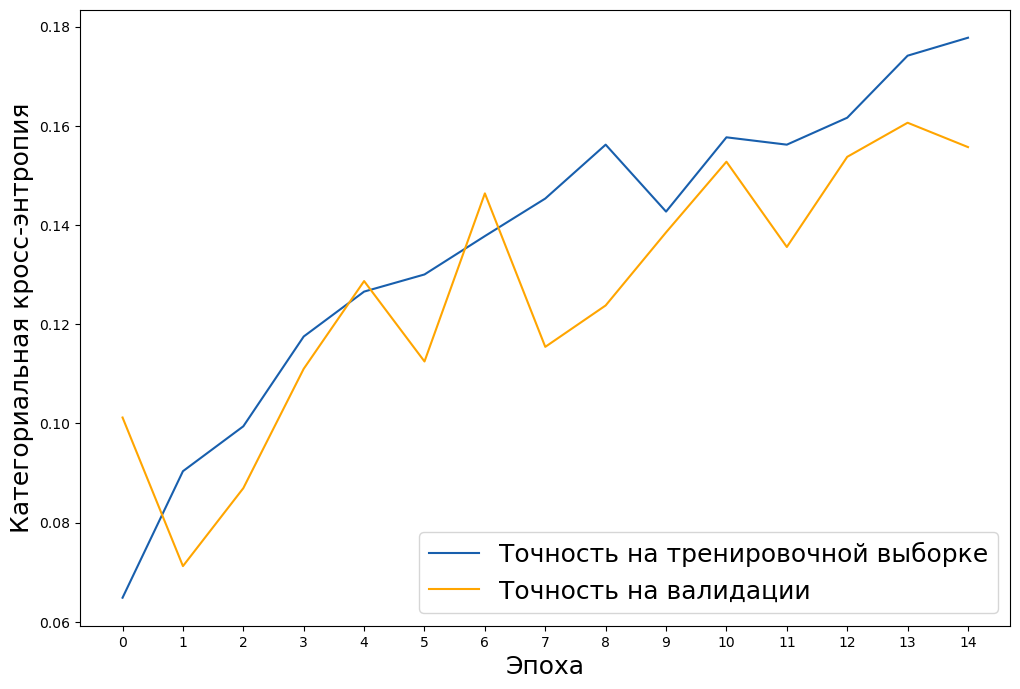

In [32]:
# тоже самое, но с accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']


plt.figure(figsize=(12, 8))


plt.plot(train_acc, label='Точность на тренировочной выборке', color='#185fad')
plt.plot(test_acc, label='Точность на валидации', color='orange')

plt.xlabel('Эпоха', fontsize = 18)
plt.ylabel('Категориальная кросс-энтропия', fontsize = 18)
plt.xticks(range(15))

plt.legend(fontsize = 18, loc="lower right");

### Финальные предсказания

In [33]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1)

252/252 [==============================] - 207s 823ms/step


In [34]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

[198   7 101 ... 173  94  39]


Результат считаю удовлетворительным